# Dog Classifier

In [2]:
# Library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import xml.etree.ElementTree as ET

from skimage.io import imread
from skimage.transform import resize
from PIL import Image
from imgaug import augmenters as iaa

import os
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split

from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.utils import *
from keras.callbacks import *

from keras.applications.densenet import DenseNet121, preprocess_input

Using TensorFlow backend.


## EDA

In [3]:
breeds = os.listdir("dogs/images/Images/")

num_breeds = len(breeds)

img_total = 0
for breed in breeds:
    img_total += len(os.listdir("dogs/images/Images/{}".format(breed)))
    
print("The dataset has {} breeds".format(num_breeds) + " and {} images".format(img_total))

The dataset has 120 breeds and 20580 images


In [4]:
# Mapping
label_maps = {}
label_maps_rev = {}
for i, v in enumerate(breeds):
    label_maps.update({v: i})
    label_maps_rev.update({i : v})

n02085620-Chihuahua


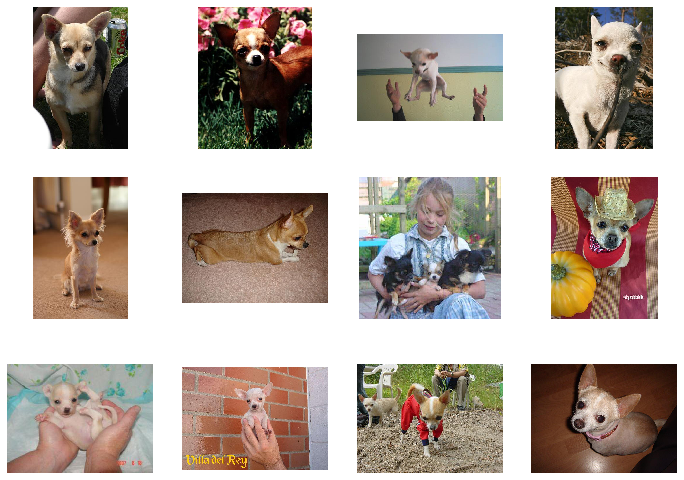

In [5]:
def show_images(breed, number_to_show):
    plt.figure(figsize=(12,12))
    img_directory = "dogs/images/Images/{}/".format(breed)
    images = os.listdir(img_directory)[:number_to_show]
    for i in range(number_to_show):
        img = mpimg.imread(img_directory + images[i])
        plt.subplot(number_to_show/4+1, 4, i+1)
        plt.imshow(img)
        plt.axis('off')
        
print(breeds[0])
show_images(breeds[0], 12)

## Preprocessing

In [7]:
%%time

# copy from https://www.kaggle.com/gabrielloye/dogs-inception-pytorch-implementation
# reduce the background noise

os.mkdir('data')
for breed in breeds:
    os.mkdir('data/' + breed)
print('Created {} folders to store cropped images of the different breeds.'.format(len(os.listdir('data'))))

for breed in os.listdir('data'):
    for file in os.listdir('dogs/annotations/Annotation/{}'.format(breed)):
        img = Image.open('dogs/images/Images/{}/{}.jpg'.format(breed, file))
        tree = ET.parse('dogs/annotations/Annotation/{}/{}'.format(breed, file))
        xmin = int(tree.getroot().findall('object')[0].find('bndbox').find('xmin').text)
        xmax = int(tree.getroot().findall('object')[0].find('bndbox').find('xmax').text)
        ymin = int(tree.getroot().findall('object')[0].find('bndbox').find('ymin').text)
        ymax = int(tree.getroot().findall('object')[0].find('bndbox').find('ymax').text)
        img = img.crop((xmin, ymin, xmax, ymax))
        img = img.convert('RGB')
        img = img.resize((224, 224))
        img.save('data/' + breed + '/' + file + '.jpg')

Created 120 folders to store cropped images of the different breeds.
Wall time: 2min 5s


In [8]:
def label_target_path():
    paths = list()
    labels = list()
    targets = list()
    for breed in breeds:
        base_name = "./data/{}/".format(breed)
        for img_name in os.listdir(base_name):
            paths.append(base_name + img_name)
            labels.append(breed)
            targets.append(label_maps[breed])
    return paths, labels, targets

paths, labels, targets = label_target_path()

assert len(paths) == len(labels)
assert len(paths) == len(targets)

targets = np_utils.to_categorical(targets, num_classes=num_breeds)

## Image augmentation

In [9]:
# copy from : https://www.kaggle.com/hengzheng/dog-breeds-classifier
# augmentates images
batch_size = 64

class ImageGenerator(Sequence):
    
    def __init__(self, paths, targets, batch_size, shape, augment=False):
        self.paths = paths
        self.targets = targets
        self.batch_size = batch_size
        self.shape = shape
        self.augment = augment
        
    def __len__(self):
        return int(np.ceil(len(self.paths) / float(self.batch_size)))
    
    def __getitem__(self, idx):
        batch_paths = self.paths[idx * self.batch_size : (idx + 1) * self.batch_size]
        x = np.zeros((len(batch_paths), self.shape[0], self.shape[1], self.shape[2]), dtype=np.float32)
        y = np.zeros((self.batch_size, num_breeds, 1))
        for i, path in enumerate(batch_paths):
            x[i] = self.__load_image(path)
        y = self.targets[idx * self.batch_size : (idx + 1) * self.batch_size]
        return x, y
    
    def __iter__(self):
        for item in (self[i] for i in range(len(self))):
            yield item
            
    def __load_image(self, path):
        image = imread(path)
        image = preprocess_input(image)
        if self.augment:
            seq = iaa.Sequential([
                iaa.OneOf([
                    iaa.Fliplr(0.5),
                    iaa.Flipud(0.5),
                    iaa.CropAndPad(percent=(-0.25, 0.25)),
                    iaa.Crop(percent=(0, 0.1)),
                    iaa.Sometimes(0.5,
                        iaa.GaussianBlur(sigma=(0, 0.5))
                    ),
                    iaa.Affine(
                        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
                        rotate=(-180, 180),
                        shear=(-8, 8)
                    )
                ])
            ], random_order=True)
            image = seq.augment_image(image)
        return image

## Train Test splits

In [10]:
X_train, X_test, y_train, y_test = train_test_split(paths, 
                                                  targets,
                                                  test_size=0.20, 
                                                  random_state=19)
train_generator = ImageGenerator(X_train, y_train, batch_size=32, shape=(224,224,3), augment=True)
test_generator = ImageGenerator(X_test, y_test, batch_size=32, shape=(224,224,3), augment=False)

## DenseNet

In [11]:
inp = Input((224, 224, 3))
backbone = DenseNet121(input_tensor=inp,
                       weights="denseNet121.h5",
                       include_top=False)
x = backbone.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
outp = Dense(num_breeds, activation="softmax")(x)

model = Model(inp, outp)

In [12]:
# Just train last 6 layers
for layer in model.layers[:-6]:
    layer.trainable = False

In [13]:
model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["acc"])

In [14]:
history = model.fit_generator(generator=train_generator, 
                              steps_per_epoch=len(train_generator), 
                              validation_data=test_generator, 
                              validation_steps=len(test_generator),
                              epochs=20)

Epoch 1/20
515/515 [==============================] - 284s 551ms/step - loss: 3.8536 - acc: 0.1164 - val_loss: 1.8926 - val_acc: 0.4434
Epoch 2/20
515/515 [==============================] - 268s 521ms/step - loss: 2.7403 - acc: 0.2699 - val_loss: 1.4115 - val_acc: 0.5879
Epoch 3/20
515/515 [==============================] - 268s 521ms/step - loss: 2.4768 - acc: 0.3331 - val_loss: 1.0833 - val_acc: 0.6142
Epoch 4/20
515/515 [==============================] - 269s 523ms/step - loss: 2.3243 - acc: 0.3683 - val_loss: 0.9457 - val_acc: 0.6224
Epoch 5/20
515/515 [==============================] - 269s 522ms/step - loss: 2.2396 - acc: 0.3872 - val_loss: 0.8576 - val_acc: 0.6290
Epoch 6/20
515/515 [==============================] - 269s 523ms/step - loss: 2.1476 - acc: 0.4108 - val_loss: 1.0182 - val_acc: 0.6385
Epoch 7/20
515/515 [==============================] - 270s 523ms/step - loss: 2.1436 - acc: 0.4111 - val_loss: 0.9877 - val_acc: 0.6368
Epoch 8/20
515/515 [============================

In [15]:
model.save('weights.h5')
# Training all layers
for layer in model.layers[:]:
    layer.trainable = True

In [16]:
# checkpoint call to save weights
checkpoint = ModelCheckpoint('weights.h5', 
                             monitor='val_acc', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='max', 
                             save_weights_only=True)

# a reducing lr callback to reduce lr when val_loss doesn't increase
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                   patience=1, verbose=1, mode='min',
                                   min_delta=0.0001, cooldown=2, min_lr=1e-7)

# for early stop
early_stop = EarlyStopping(monitor="val_loss", mode="min", patience=5)

In [17]:
history = model.fit_generator(generator=train_generator, 
                              steps_per_epoch=len(train_generator), 
                              validation_data=test_generator, 
                              validation_steps=len(test_generator),
                              epochs=20,
                              callbacks=[checkpoint, reduce_lr, early_stop])

Epoch 1/20
515/515 [==============================] - 271s 525ms/step - loss: 1.9632 - acc: 0.4616 - val_loss: 0.8792 - val_acc: 0.6672

Epoch 00001: val_acc improved from -inf to 0.66715, saving model to model.h5
Epoch 2/20
515/515 [==============================] - 272s 529ms/step - loss: 1.9466 - acc: 0.4672 - val_loss: 0.9597 - val_acc: 0.6718

Epoch 00002: val_acc improved from 0.66715 to 0.67177, saving model to model.h5

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 3/20
515/515 [==============================] - 272s 528ms/step - loss: 1.7562 - acc: 0.5079 - val_loss: 0.8000 - val_acc: 0.6997

Epoch 00003: val_acc improved from 0.67177 to 0.69971, saving model to model.h5
Epoch 4/20
515/515 [==============================] - 273s 529ms/step - loss: 1.7001 - acc: 0.5229 - val_loss: 0.7615 - val_acc: 0.7087

Epoch 00004: val_acc improved from 0.69971 to 0.70870, saving model to model.h5
Epoch 5/20
515/515 [==============================] -

In [18]:
model.save('weights.h5')

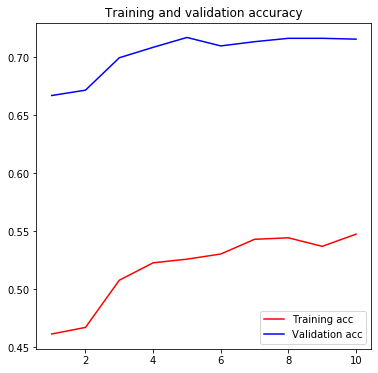

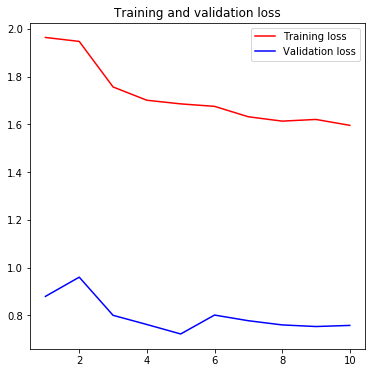

In [19]:
plt.rcParams['figure.figsize'] = (6,6)

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

In [20]:
print(max(val_acc))

0.7172011733055115
